# EDA: GeoVisualizations

## Imports

In [2]:
from urllib.request import urlopen
import pandas as pd
import plotly.express as px
import json

In [ ]:
# !pip install plotly-geo
# !pip install geopandas
# !pip install pyshp
# !pip install shapely

## Load in Data 

In [4]:
covid_data = []
folder_name = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
covid_data.append(
    folder_name + 'time_series_covid19_confirmed_US.csv'
)
covid_data.append(
    folder_name + 'time_series_covid19_deaths_US.csv'
)

df_covid_conf = pd.read_csv(
    covid_data[0]
)
df_covid_dead = pd.read_csv(
    covid_data[1]
)

In [5]:
df_covid_conf.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,6926,6928,6938,6971,7001,7005,7010,7015,7017,7049
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,21154,21170,21191,21290,21392,21411,21422,21444,21467,21489
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2310,2314,2317,2319,2320,2320,2320,2322,2324,2326
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2609,2612,2615,2630,2645,2647,2648,2651,2652,2656
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,6678,6680,6694,6750,6771,6773,6776,6794,6808,6816


In [6]:
df_covid_dead.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,108,108,108,108,108,108,108,108,108,109
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,308,309,309,309,310,310,310,310,310,310
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,57,56,56,56,56,56,56,56,56,58
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,64,64,64,64,64,64,64,64,64,64
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,137,137,137,139,139,139,139,139,139,139


The data in this notebook was pulled directly from John Hopkins' Covid data Github.

## Reformat Dataframes 

In [11]:
df_covid = (
    df_covid_dead[df_covid_dead.FIPS > 1000]
)[df_covid_dead.FIPS < 80000].copy()  
df_conf = (
    df_covid_conf[df_covid_conf.FIPS > 1000]
)[df_covid_conf.FIPS < 80000].copy()

<ipython-input-11-58b2527107c8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_covid = (
<ipython-input-11-58b2527107c8>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_conf = (


To filter counties that have FIP IDs.

In [12]:
num_days = 30
df_conf_ts = (
    (
        (df_conf.set_index('FIPS')).T
     ).drop(['iso2', 'iso3', 'UID', 'code3', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key']
         ).diff(periods=num_days) / 1.0
)
df_dead_ts = (
    (
        (df_covid.set_index('FIPS')).T
     ).drop(['iso2', 'iso3', 'UID', 'code3', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key',
          'Population', ]
         ).diff(periods=num_days) / 1.0
)

df_conf_ts_cum = (
    (
        (df_conf.set_index('FIPS')).T
     ).drop(['iso2', 'iso3', 'UID', 'code3', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key']
         )
)
df_dead_ts_cum = (
    (
        (df_covid.set_index('FIPS')).T
     ).drop(['iso2', 'iso3', 'UID', 'code3', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key','Population', ]
         )
)

In order to create visualizations that look at confirmed COVID cases in the last 30 days per 100k people in a county, show the growth of COVID cases by county, and show COVID deaths per one million residents, we'll need to follow a few steps. We'll create four dataframes, the first two looking at the data as a time series and the last two tracking the cumulative numbers. 

In [13]:
df = pd.DataFrame(
    {
        'FIPS': df_covid['FIPS'],
        'State': df_covid['Province_State'],
        'County': df_covid['Admin2'],
        'Population': df_covid['Population'],
        'Confirmed': df_conf_ts.values[-1],
        'Death': df_dead_ts.values[-1],
        'Death_total': df_dead_ts_cum.values[-1],
        'Confirmed_earlier': df_conf_ts.values[-1 - num_days],
        'Death_earlier': df_conf_ts.values[-1 - num_days]
    },
)

Package these new features together in a single dataframe to create the models below.

In [14]:
df = df[df.Population > 0]
df['Confirmed_per_100k'] = df.Confirmed / df.Population * 100_000
df['Confirmed_Growth_per_100k'] = (
    df.Confirmed - df.Confirmed_earlier
    ) / df.Population * 100_000
df['Total_Death_per_mil'] = df.Death_total / df.Population * 100_000
df = df.drop(
    columns = ['Confirmed','Death','Death_total','Confirmed_earlier','Death_earlier',]
)      

df['FIPS'] = df['FIPS'].astype('int64', copy=True)
df['FIPS'] = df['FIPS'].astype('str', copy=True)
df['FIPS'] = df['FIPS'].str.rjust(5, '0')

df = df.set_index('FIPS')

Here we do some additional cleaning and feature engineering for the plotting.

## Geovisualizations

I ran the graphs below in Google Colab but they're not outputting in Jupyter Notebook. PNGs of the output are in the markdowns below.

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
fig = px.choropleth_mapbox(df.reset_index(), 
                           geojson=counties, locations='FIPS', color='Confirmed_per_100k',
                           color_continuous_scale='jet',
                           range_color=(100, 1500),
                           mapbox_style="carto-positron",
                           hover_name='County',                           
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Confirmed_per_100k':'Last 30 days data'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

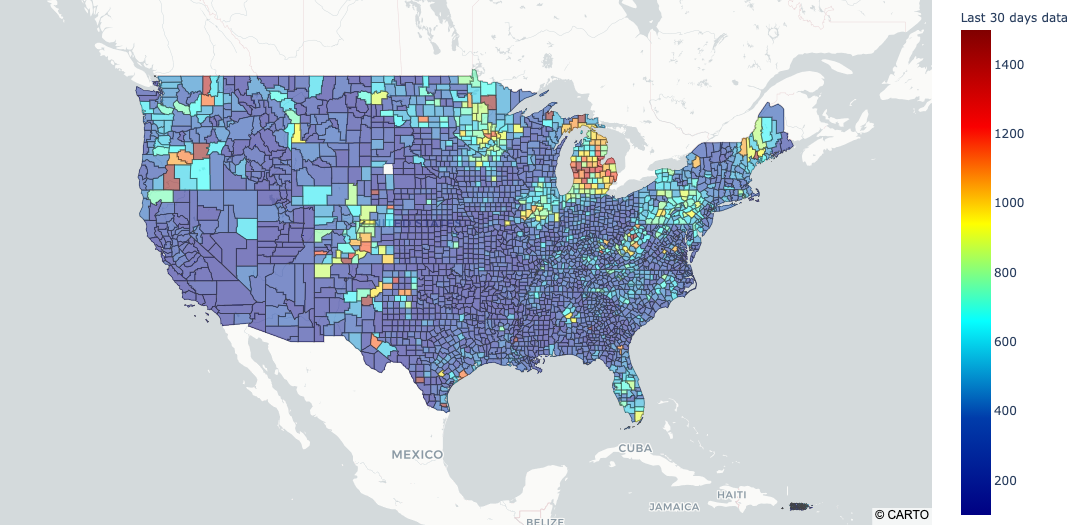

Looking at the confirmed cases in the last 30 days, we can see that the majority of the country reported relatively low numbers of new cases, with the notable exception of an outbreak in Michigan.  Aside from that, the counties with cases of ~600 and above are occuring mostly in rural communities.  

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
fig = px.choropleth_mapbox(df_presentation.reset_index(), 
                           geojson=counties, locations='FIPS', color='Confirmed_Growth_per_100k',                           
                           color_continuous_scale='jet',
                           range_color=(-200, 200),
                           mapbox_style="carto-positron",
                           hover_name='County',                           
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Confirmed_Growth':'Growth in last 2 weeks'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

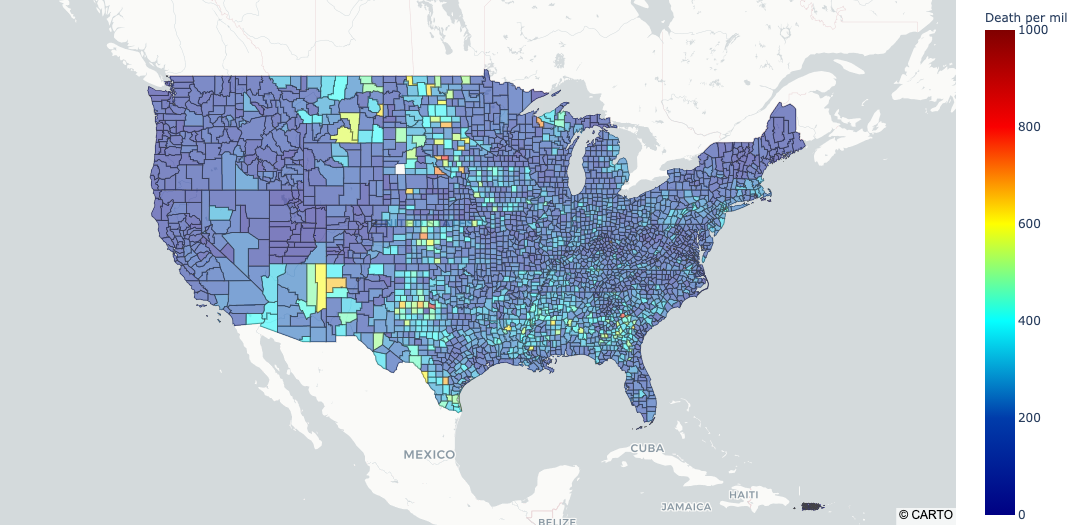

Similar to the graph above, deaths per million by county are higher in rural communites than they are in urban areas.

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
fig = px.choropleth_mapbox(df_presentation.reset_index(), 
                           geojson=counties, locations='FIPS', color='Total_Death_per_mil',                           
                           color_continuous_scale='jet',
                           range_color=(0, 1000),
                           mapbox_style="carto-positron",
                           hover_name='County',                           
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Total_Death_per_mil':'Death per mil'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

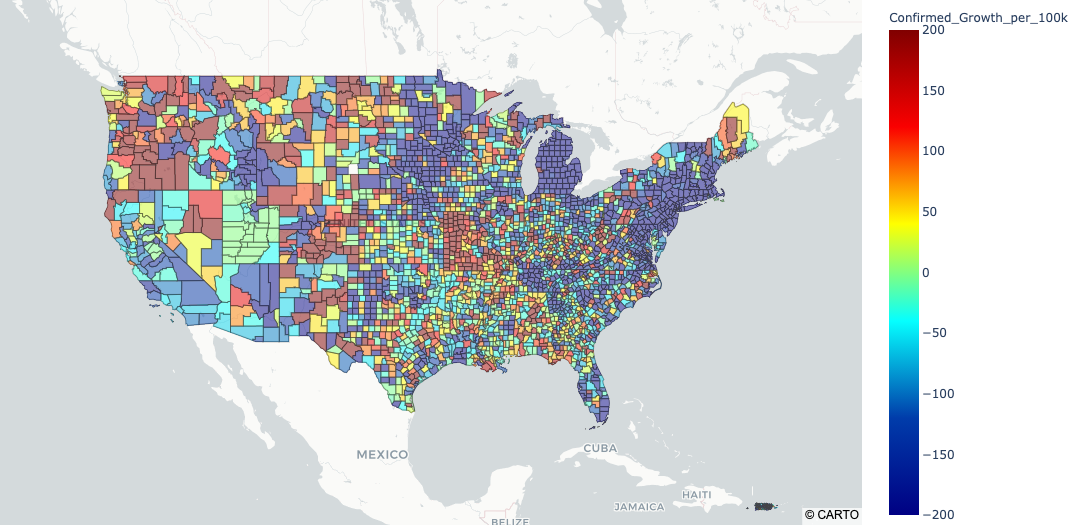

As of a month ago, growth was occuring in mostly rural counties with hotspots emerging in Missouri, Colorado, and the Pacific Northwest. My main takeaway from these three plots is that rural communities are more likely to have more confirmed cases, more deaths, and more growth than more populated counties. 

In [7]:
# https://towardsdatascience.com/how-to-build-plotly-choropleth-map-with-covid-data-using-pandas-in-google-colab-45951040b8e4